In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from collections import Counter

import warnings


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
header = pd.read_csv("all_jurnal_header.csv", dtype={"id" : str})

In [3]:
comment = pd.read_csv("all_jurnal.csv", dtype={"jurnal_id" : str})

In [4]:
# Fungsi untuk membersihkan komentar
def clean_comment(comment):
    # Menghapus karakter khusus, emotikon, dan simbol lainnya
    cleaned_comment = re.sub(r'[^\w\s]', '', comment)
    # Tokenisasi kata
    tokens = word_tokenize(cleaned_comment)
    # Menghapus stopwords
    stopword_factory = StopWordRemoverFactory()
    stopwords = stopword_factory.get_stop_words()
    filtered_tokens = [word for word in tokens if word.lower() not in stopwords]
    # Stemming kata
    stemmer_factory = StemmerFactory()
    stemmer = stemmer_factory.create_stemmer()
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    # Menggabungkan kembali token menjadi kalimat
    cleaned_comment = ' '.join(stemmed_tokens)
    return cleaned_comment

# Fungsi untuk menganalisis komentar
def analyze_comments(data):
    # Membersihkan komentar
    data['cleaned_comment'] = data['comment'].apply(clean_comment)
    # # Menghitung frekuensi kata-kata
    # word_freq = Counter(" ".join(data['cleaned_comment']).split()).most_common(10)
    # # Mencetak kata-kata yang paling sering muncul
    # print("Top 10 Kata yang Paling Sering Muncul:")
    # for word, freq in word_freq:
    #     print(f"{word}: {freq}")
    
    return data

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Fungsi untuk membuat dan menampilkan WordCloud
def generate_wordcloud(data):
    # Menggabungkan semua komentar menjadi satu string
    text = " ".join(word for word in data['comment_removed'])
    # Membuat objek WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    # Menampilkan WordCloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('WordCloud dari Komentar')
    plt.show()

# Analysis Jurnal

In [6]:
header.groupby("jurnal_type", as_index=False).agg(
    {"id": "nunique", "like_count": "sum", "comment_count": "sum"}
)

,jurnal_type,id,like_count,comment_count
0,post,8,850,1500


Text(0.5, 1.0, 'Like Count')

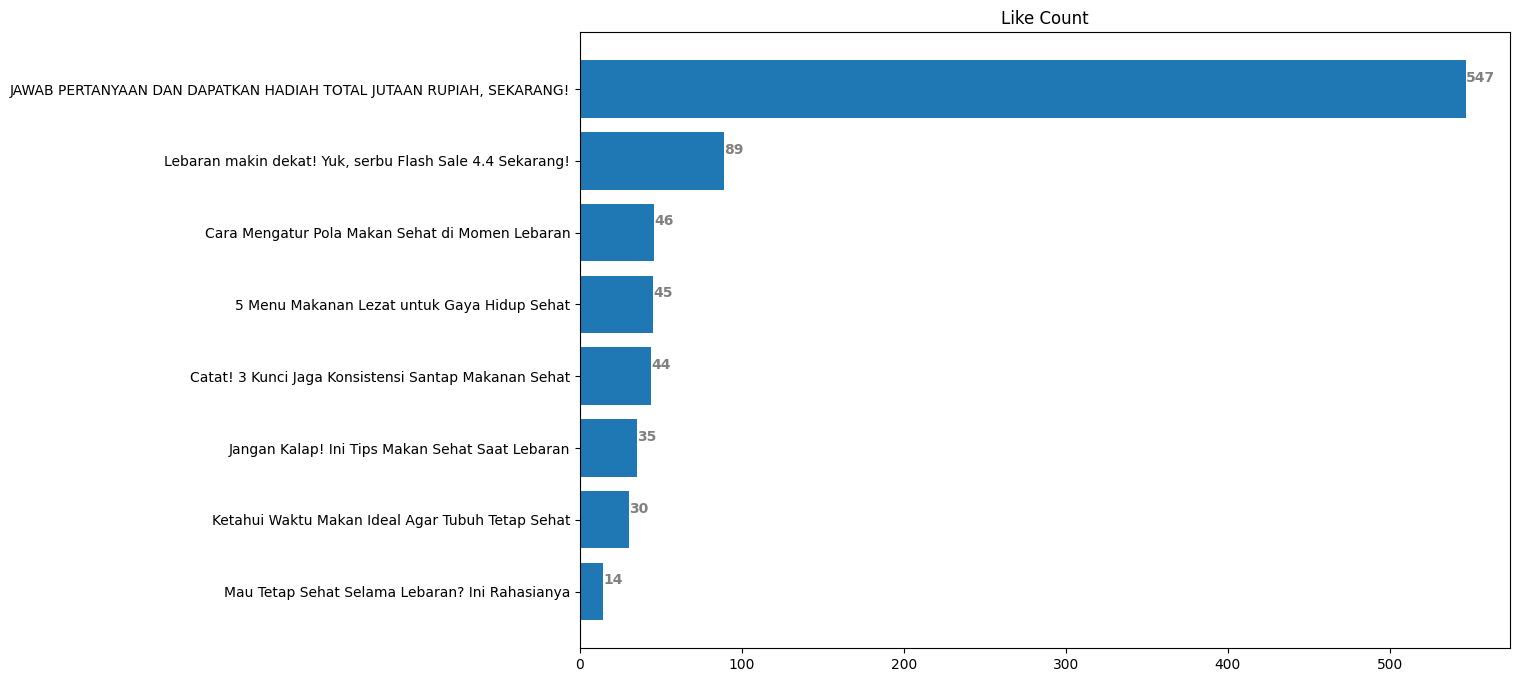

In [7]:
# Figure Size
fig, ax = plt.subplots(figsize=(12, 8))

# Horizontal Bar Plot
ax.barh(
    data=header.sort_values(by="like_count", ascending=True),
    y="title",
    width="like_count",
)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5, 
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
    
ax.set_title('Like Count')

Text(0.5, 1.0, 'Comment Count')

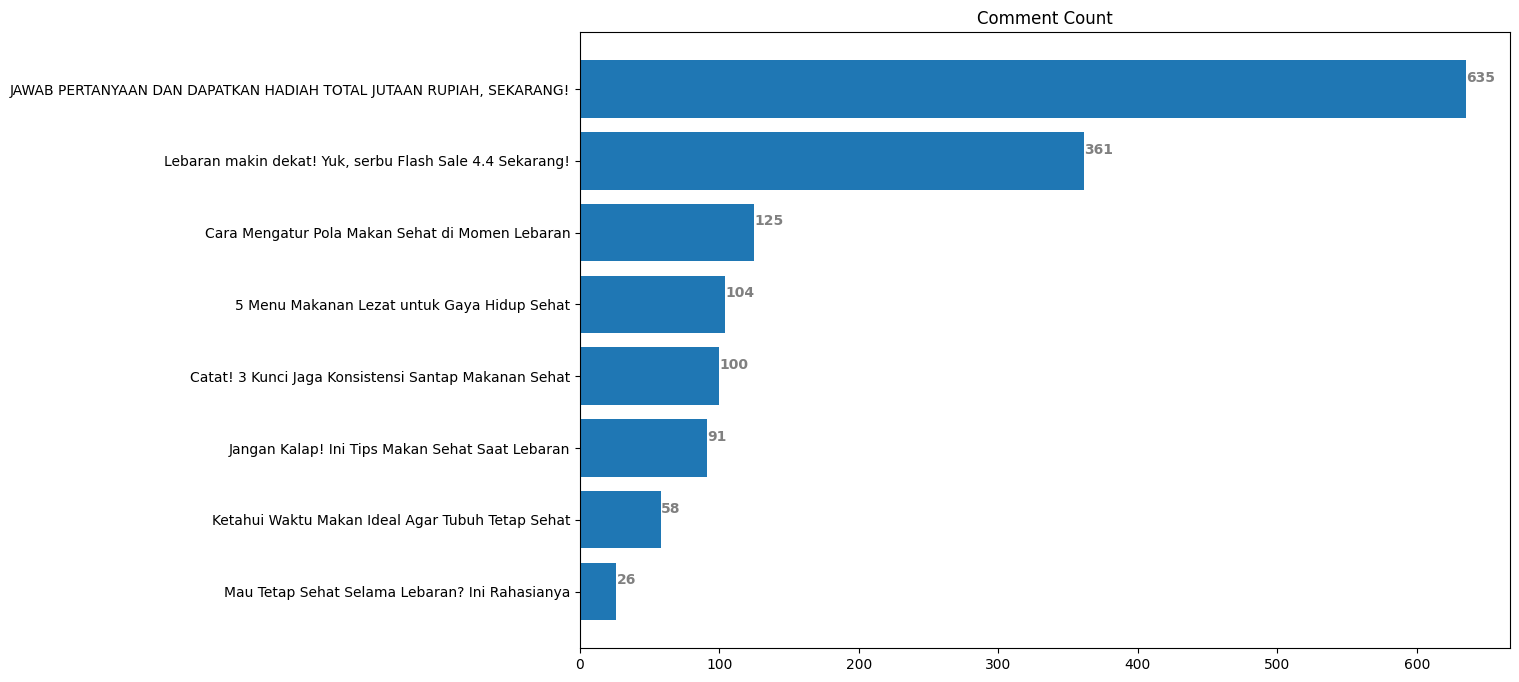

In [8]:
# Figure Size
fig, ax = plt.subplots(figsize=(12, 8))

# Horizontal Bar Plot
ax.barh(
    data=header.sort_values(by="comment_count", ascending=True),
    y="title",
    width="comment_count",
)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5, 
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
    
ax.set_title("Comment Count")

# WordCloud

In [9]:
def cleaning_comment(comment):
    comment = comment.lower()
    
    comment = comment.replace("terima kasih", "terimakasih")
    comment = comment.replace("maksih", "terimakasih") 
    comment = comment.replace("makasih", "terimakasih") 
    comment = comment.replace("thanks", "terimakasih")
    comment = comment.replace("thx", "terimakasih")
    comment = comment.replace("teriterimakasih", "terimakasih")
    comment = comment.replace("triterimakasih", "terimakasih")
    comment = comment.replace("ttwrimakasieriterimakasih", "terimakasih")
    comment = comment.replace("yg", "yang")
    
    clean_comment = re.sub(r'[^\w\s]', '', comment)
    clean_comment = clean_comment.lower()
    return clean_comment

In [10]:
comment['comment_clean'] = comment['comment'].apply(cleaning_comment)

In [11]:
df = comment[~(comment['jurnal_id'] == '103785')]

In [12]:
word_freq = Counter(' '.join(df['comment_clean']).split())

In [13]:
list_update_stopwords = [word for word in word_freq.keys() if len(word) <= 3]

In [14]:
len(list_update_stopwords)

120

In [15]:
df['comment_token'] = df['comment_clean'].str.split(' ')

In [16]:
stopword_factory = StopWordRemoverFactory()
stopwords = stopword_factory.get_stop_words()
stopwords = stopwords + list_update_stopwords

In [17]:
def remove_stopwods(comment):
    comment_removed = [word for word in comment if word not in stopwords]
    comment_removed = ' '.join(comment_removed).strip()
    return comment_removed

In [18]:
df['comment_removed'] = df['comment_token'].apply(remove_stopwods)

In [19]:
word_freq_removed = Counter(' '.join(df['comment_removed']).split())

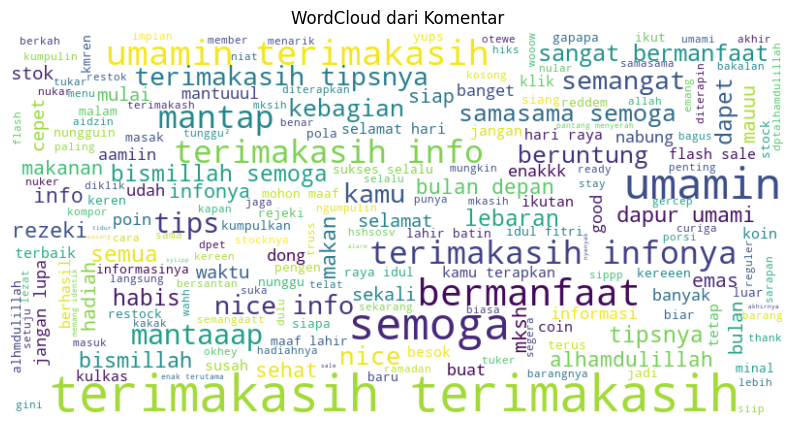

In [20]:
generate_wordcloud(df)

Dapat kita lihat bahwa dari komen - komen yang ada di campaign (jurnal) yang diterbitkan pada bulan April mayoritas pada #Umamin ini berterimakasih. 

In [22]:
word_freq_removed.most_common(10)

[('terimakasih', 174),
 ('umamin', 66),
 ('semoga', 64),
 ('info', 43),
 ('bermanfaat', 39),
 ('infonya', 28),
 ('nice', 27),
 ('tipsnya', 24),
 ('mantap', 21),
 ('bismillah', 19)]

Terdapat 174 kata 'Terimakasih' yang diucapkan oleh #Umami.

In [23]:
df = header[['id', 'title']].rename(columns={'id' : 'jurnal_id'}).merge(
    df,
    'right',
    on='jurnal_id'
    )

In [24]:
df_terimakasih = df[df["comment_removed"].str.contains("terimakasih")].groupby(
    ["jurnal_id", "title"], as_index=False
).agg({"comment_removed": "size"}).merge(
    header[["id", "comment_count"]].rename(
        columns={"id": "jurnal_id", "comment_count": "comment_total"}
    ),
    "left",
    on=["jurnal_id"]
)

df_terimakasih['percentage'] = df_terimakasih['comment_removed'] / df_terimakasih['comment_total']

In [25]:
df_terimakasih

,jurnal_id,title,comment_removed,comment_total,percentage
0,102163,"Lebaran makin dekat! Yuk, serbu Flash Sale 4.4...",7,361,0.019391
1,104179,Jangan Kalap! Ini Tips Makan Sehat Saat Lebaran,27,91,0.296703
2,104520,Cara Mengatur Pola Makan Sehat di Momen Lebaran,28,125,0.224000
3,104837,Mau Tetap Sehat Selama Lebaran? Ini Rahasianya,8,26,0.307692
4,106090,5 Menu Makanan Lezat untuk Gaya Hidup Sehat,38,104,0.365385
5,106878,Ketahui Waktu Makan Ideal Agar Tubuh Tetap Sehat,18,58,0.310345
6,107582,Catat! 3 Kunci Jaga Konsistensi Santap Makanan...,48,100,0.480000
